In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer,f1_score,recall_score,precision_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance

import eli5
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer,f1_score,recall_score,precision_score
import pickle

In [5]:
X = pd.read_csv('churnfeatures.csv')
y = pd.read_csv('churnlabel.csv')
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state = 12,stratify = y)
lgb = pickle.load(open('lgb.pkl', 'rb'))

### Find an optimal prediction threshold according to maximun expected profit 

In [11]:
# Bussiness senario

response_rate_poss = np.arange(0.05,0.95,0.05)
response_value = 300
marketing_cost = 10 

In [12]:
profit = {
    'fn': 0,
    'tn': 0,
    'tp': response_value,
    'fp': -1*marketing_cost
}

def expected_profit(profit,tn, fp, fn, tp,response_rate):
    
    return ((profit['tp']*tp*response_rate)+(profit['fp']*(fp + tp*(1-response_rate))))/(fn+tn+tp+fp)


In [13]:
def find_optimal_thresh(lgb, profit,response_rate):
    thresh_vals = np.arange(0, 1.001, 0.001)
    thresh_dict = {}
    for t in thresh_vals:
        preds = (lgb.predict_proba(X_test)[:, 1] > t).astype('int')
        TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()
        EP = expected_profit(profit, TN, FP, FN, TP,response_rate)
        thresh_dict[t] = EP
    best_threshold = max(thresh_dict.items(), key=lambda x: x[1])[0]
    lowest_EP = min(thresh_dict.items(), key=lambda x: x[1])[1]
    highest_EP = max(thresh_dict.items(), key=lambda x: x[1])[1]
    thresholds = [t for t in thresh_dict.keys()]
    profits= [c for c in thresh_dict.values()]
    return thresholds, profits, best_threshold, highest_EP
    
def plot_optimal_thresh(thresholds, profits, best_threshold, highest_EP):    
    # Plot figure
    plt.figure(figsize=(6.3, 6.3))
    plt.plot(thresholds, profits, c='red', label='profit curve')
    plt.plot([0, 1], [highest_EP, highest_EP], 'k-', label='max profit')
    plt.plot([best_threshold, best_threshold], [0, highest_EP], 'k-')
    plt.ylim([0, 20])
    plt.legend()
    plt.title('Classification Threshold vs Expected Profit ')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Expected Profit')
    plt.margins(0)
    plt.show()

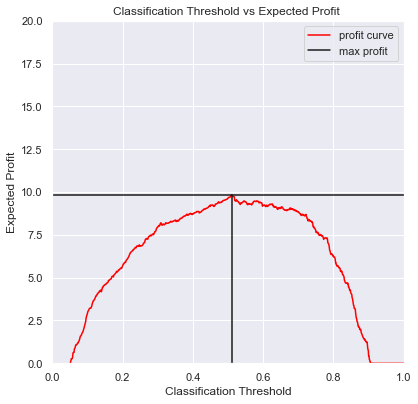

Best threshold:  0.51
profit from per cutomer:   £9.83


In [124]:
# Find optimal threshold

    
    
ts_gb, cs_gb, bt_gb, lc_gb = find_optimal_thresh(lgb, profit,response_rate)

Output and plot evaluation metrics
xgb_evals_dict = OrderedDict()
plot_roc_pr(clf_xgb)
plot_optimal_thresh(ts_gb, cs_gb, bt_gb, lc_gb)
xgbt1 = time()
metrics(clf_name=clf_xgb, thresh=bt_xgb, ordered_dict=xgb_evals_dict)
xgb_predictiontime = time()-xgbt1
print('Training time:   {:.2f} sec.'.format(xgb_trainingtime))
print('Prediction time: {:.2f} sec.'.format(xgb_predictiontime))
print('Best threshold:  {:.2f}'.format(bt_gb))
print('profit from per cutomer:   £{:.2f}'.format(lc_gb))

In [20]:
Best_threshold = []
Max_profit = []
F1_score =[]
Precison_score = []
Recall_score = []
Roc_Auc_score =[]
    
for response_rate in response_rate_poss:
    
    _, _, best_threshold, highest_EP = find_optimal_thresh(lgb, profit,response_rate)
    pred = (lgb.predict_proba(X_test)[:, 1] > best_threshold).astype('int')
    
    Best_threshold.append(best_threshold)
    Max_profit.append(highest_EP)
    F1_score.append(f1_score(y_test,pred))
    Precison_score.append(precision_score(y_test,pred))
    Recall_score.append(recall_score(y_test,pred))
    Roc_Auc_score.append(roc_auc_score(y_test,pred))

Threshold_of_Response_rate = pd.DataFrame({'Response Rate':response_rate_poss,
                                           'Threshold':Best_threshold,
                                           'Maximum Profit':Max_profit,
                                          'F1 Score':F1_score,
                                          'Precision':Precison_score,
                                          'Recall':Recall_score,
                                          'ROCAUC':Roc_Auc_score})

In [21]:
Threshold_of_Response_rate.to_csv('Threshold_of_Response_rate.csv',index=False)

f1-score: 0.660655737704918
precision 0.5351925630810093
recall 0.8629550321199143
roc_auc: 0.7962379488265724


Text(0.5, 440.31090909090915, 'Predicted Values')

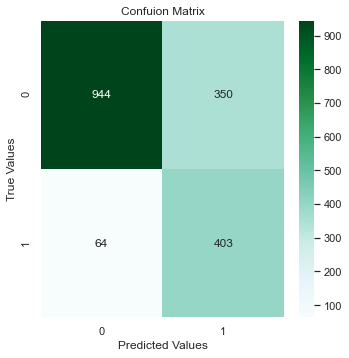

In [127]:
print('f1-score:', f1_score(y_test,pred))
print('precision',precision_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))
conf_matrix = confusion_matrix(y_test,pred)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='BuGn')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

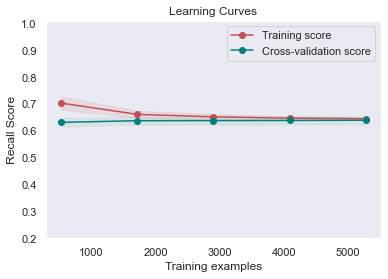

In [19]:
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Recall Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="teal",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size = 0.25, random_state=12)

estimator = lgb1
plot_learning_curve(estimator, title, X, y, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

# title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [129]:
perm1 = PermutationImportance(lgb, random_state = 12, scoring ='recall',n_iter = 100).fit(X_train, y_train)
eli5.show_weights(perm1, feature_names = X_train.columns.tolist())

Weight,Feature
0.0834 ± 0.0137,Tenure_Months
0.0749 ± 0.0123,Contract_Month-to-month
0.0695 ± 0.0128,Dependents
0.0567 ± 0.0123,Contract_Two year
0.0411 ± 0.0116,Internet_Service_Fiber optic
0.0124 ± 0.0044,Streaming_Movies
0.0117 ± 0.0085,Internet_Service_No
0.0115 ± 0.0030,Monthly_Charges
0.0109 ± 0.0048,Streaming_TV
0.0089 ± 0.0048,Total_Charges


# Churn probability distribution over clusters

In [57]:
X_cluster = pd.read_csv('data_with_clusters.csv')
X_test['Cluster']=X_cluster.loc[X_test.index,'cluster_kpca_rbf']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
index_cluster0 = data[data.cluster_kpca_rbf == 0].index.values
index_cluster1 = data[data.cluster_kpca_rbf == 1].index.values
index_cluster2 = data[data.cluster_kpca_rbf == 2].index.values
index_cluster3 = data[data.cluster_kpca_rbf == 3].index.value

Text(0.5, 1.0, 'Churn probability distribution')

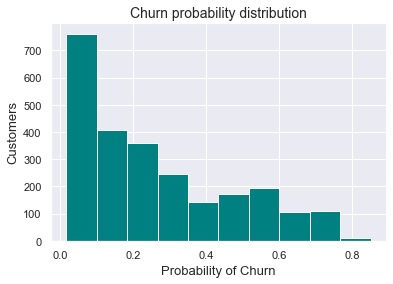

In [182]:
pred_cluster0 = lgb.predict_proba(X.iloc[index_cluster0,:])
plt.hist( pred_cluster0[:,1], bins = 10,color='teal')
plt.xlabel("Probability of Churn", fontsize=13)
plt.ylabel("Customers", fontsize=13)

plt.title("Churn probability distribution", fontsize=14)

Text(0.5, 1.0, 'Churn probability distribution')

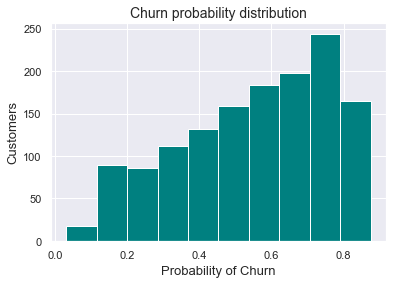

In [183]:
pred_cluster3 = lgb.predict_proba(X.iloc[index_cluster3,:])
plt.hist( pred_cluster3[:,1], bins = 10,color='teal')
plt.xlabel("Probability of Churn", fontsize=13)
plt.ylabel("Customers", fontsize=13)

plt.title("Churn probability distribution", fontsize=14)

Text(0.5, 1.0, 'Churn probability distribution')

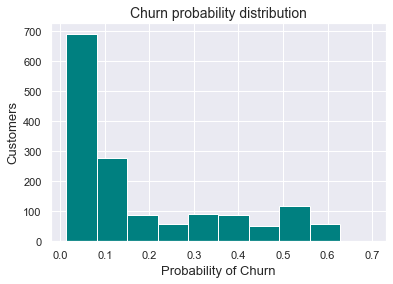

In [181]:
pred_cluster2 = lgb.predict_proba(X.iloc[index_cluster2,:])
plt.hist( pred_cluster2[:,1], bins = 10,color='teal')
plt.xlabel("Probability of Churn", fontsize=13)
plt.ylabel("Customers", fontsize=13)

plt.title("Churn probability distribution", fontsize=14)

Text(0.5, 1.0, 'Churn probability distribution')

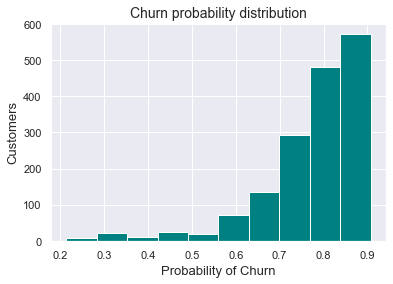

In [180]:
pred_cluster1 = lgb.predict_proba(X.iloc[index_cluster1,:])
plt.hist( pred_cluster1[:,1], bins = 10,color='teal')

plt.xlabel("Probability of Churn", fontsize=13)
plt.ylabel("Customers", fontsize=13)

plt.title("Churn probability distribution", fontsize=14)

# Model interpretation and feature importance

In [48]:
import shap

In [49]:
cmap=['#008080','#808080']

In [24]:
import shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


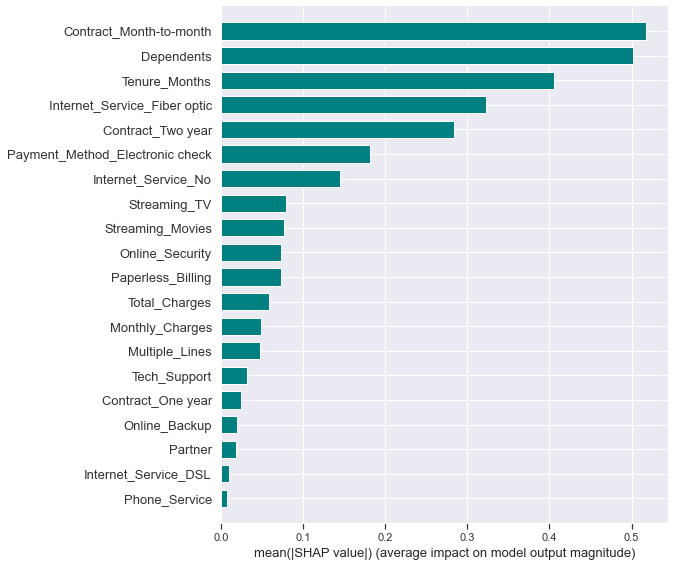

In [42]:
shap.initjs()

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_test)
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)

shap.summary_plot(shap_values[1], X_test, plot_type= 'bar',color='teal')

invalid value encountered in true_divide
invalid value encountered in true_divide


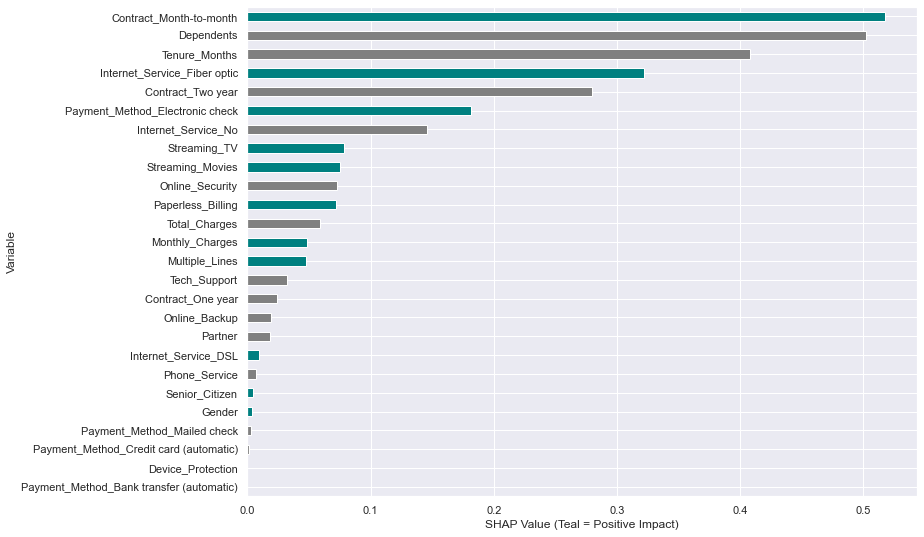

In [26]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'teal','grey')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(12,9),legend=False)
    ax.set_xlabel("SHAP Value (Teal = Positive Impact)")
    
ABS_SHAP(shap_values[1],X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


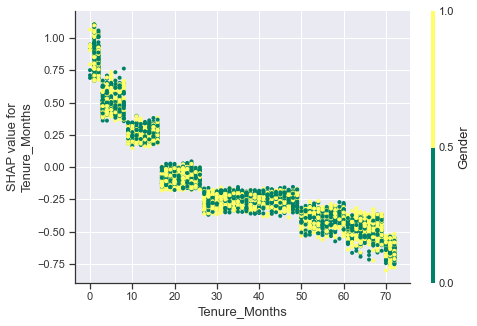

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


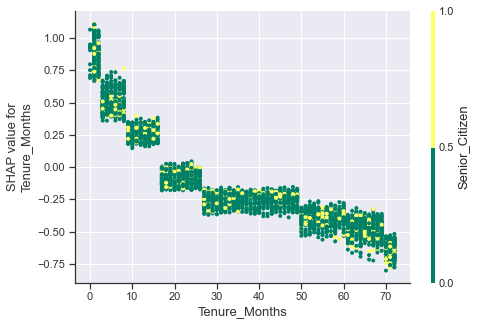

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


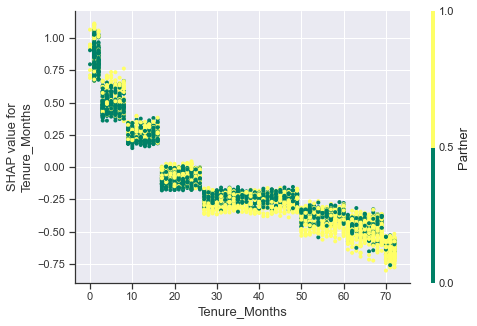

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


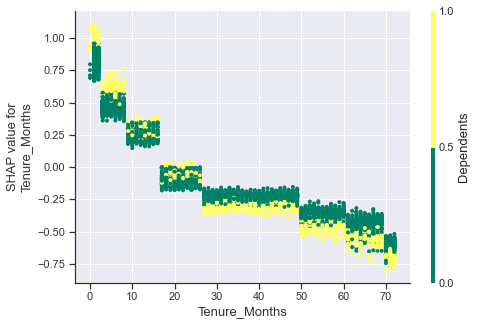

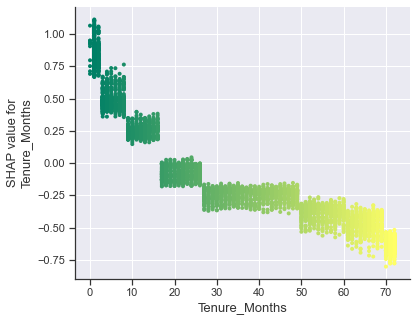

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


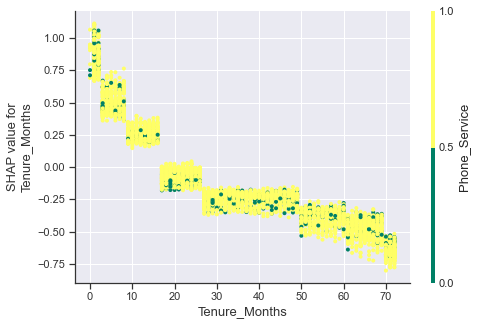

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


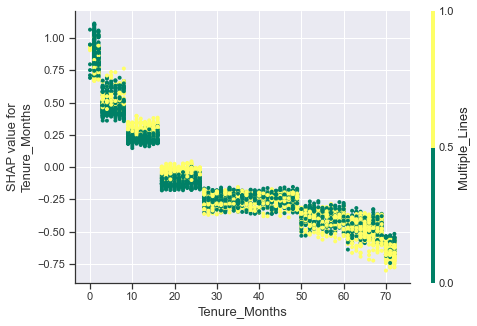

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


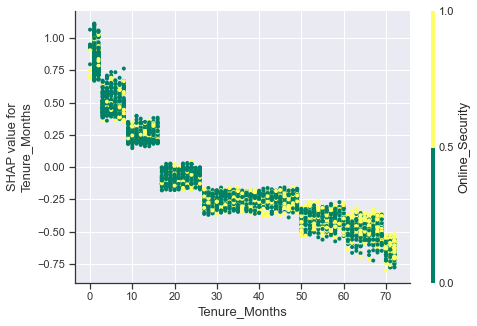

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


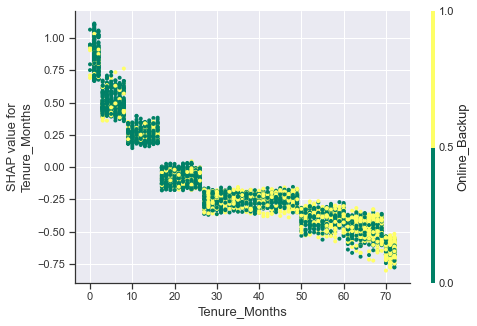

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


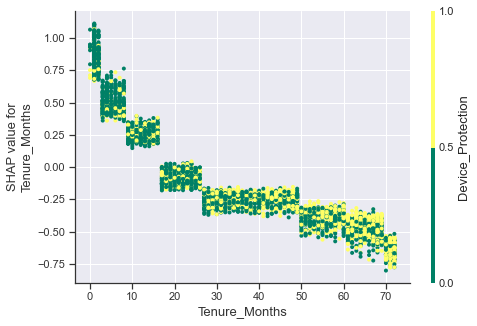

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


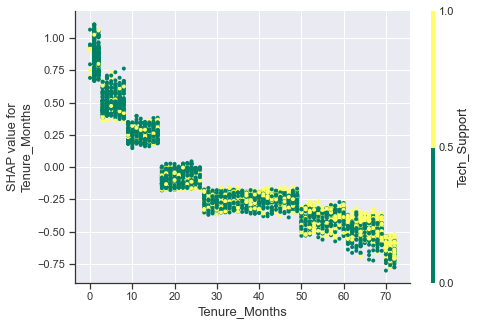

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


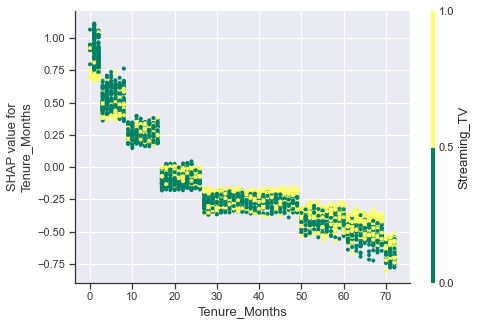

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


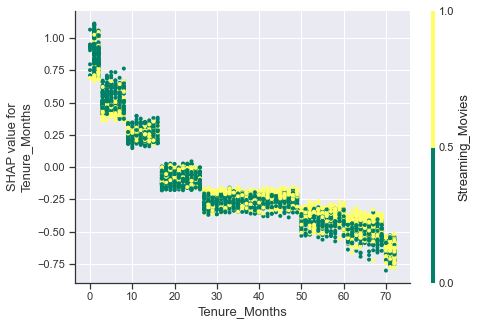

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


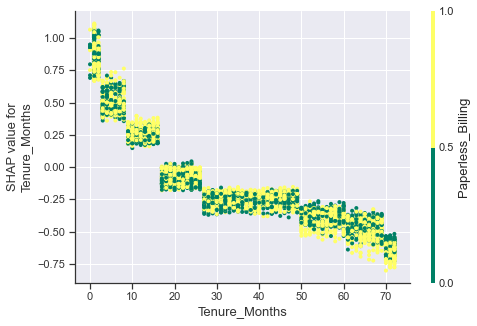

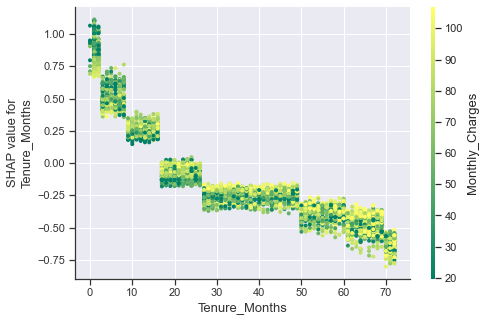

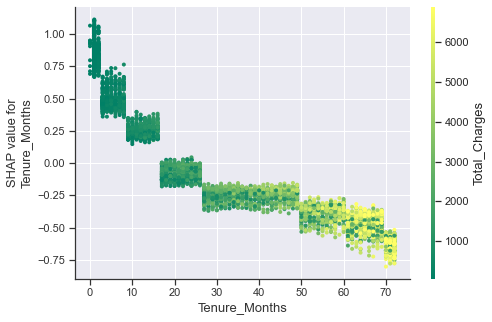

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


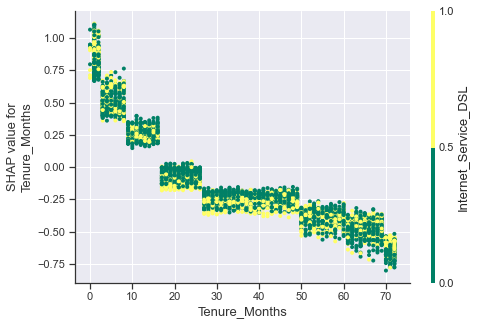

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


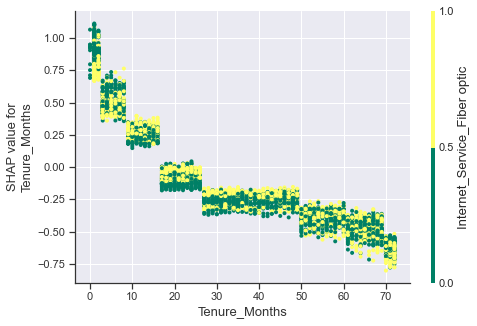

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


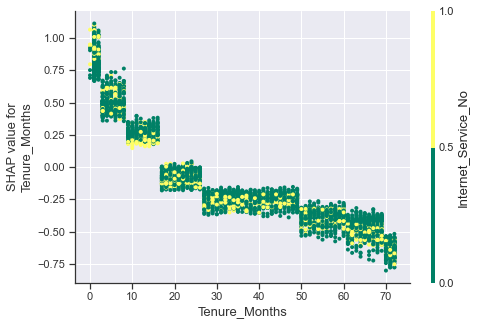

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


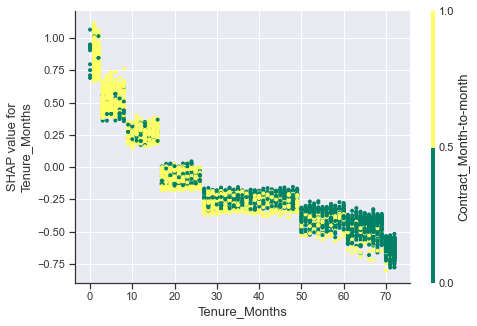

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


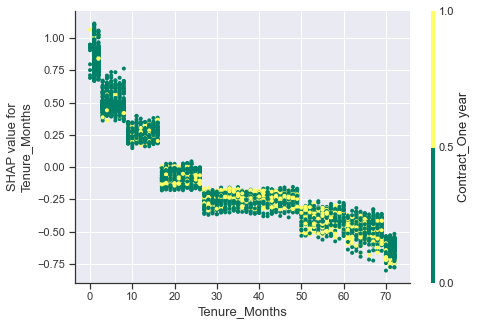

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


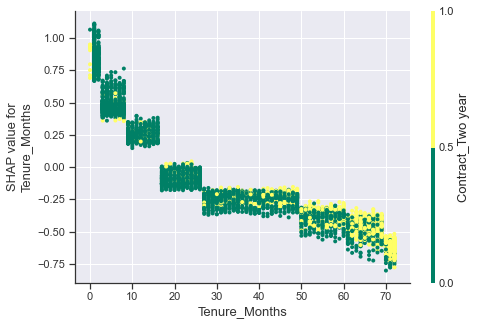

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


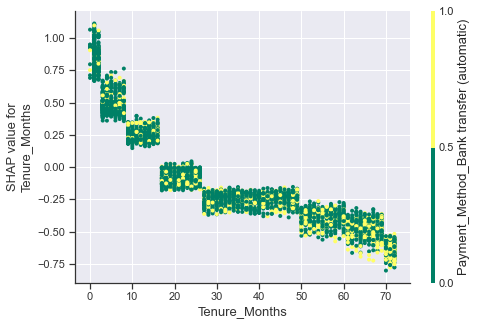

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


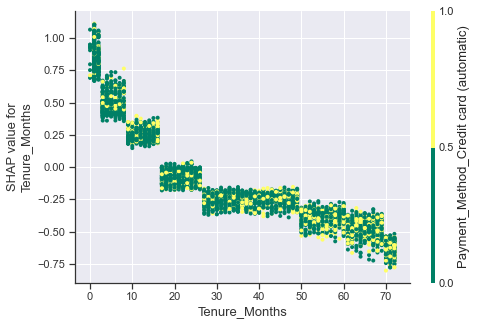

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


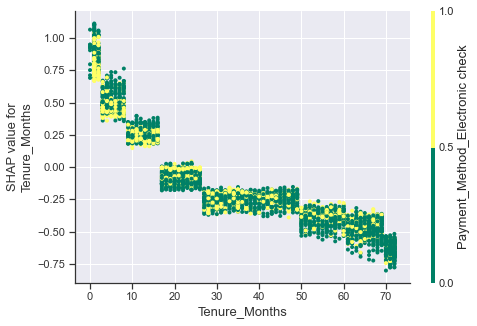

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


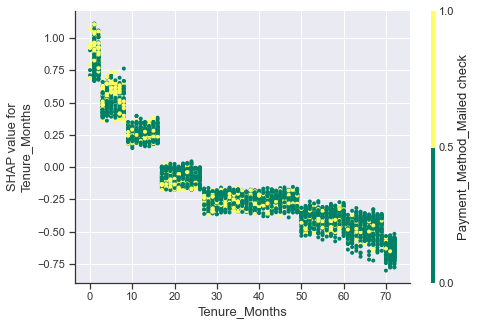

In [62]:
# Check relationship between 'Tenure_Months' and other features

for i in range(0,len(X_train.columns)):    
    shap.dependence_plot('Tenure_Months', 
                         shap_values[1], 
                         X_train,
                         interaction_index= X_train.columns[i], 
                         cmap=plt.get_cmap("summer"))

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


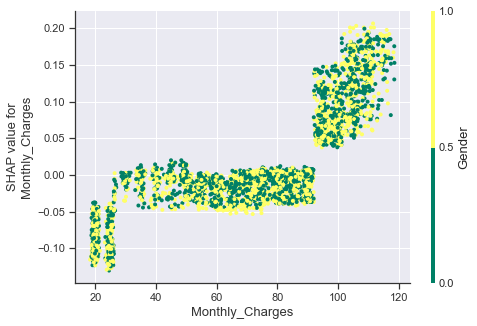

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


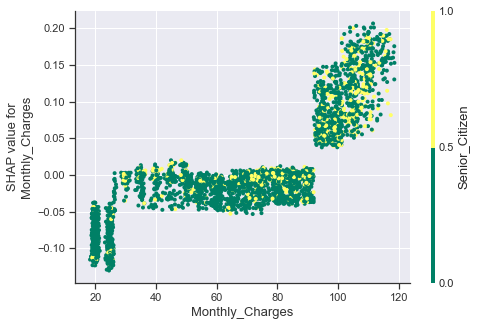

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


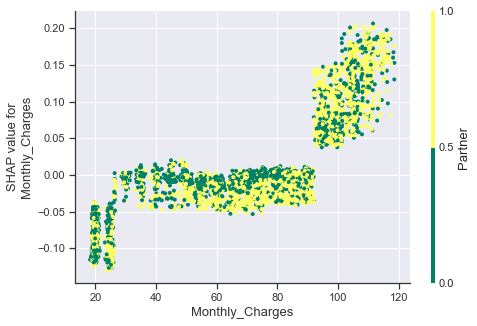

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


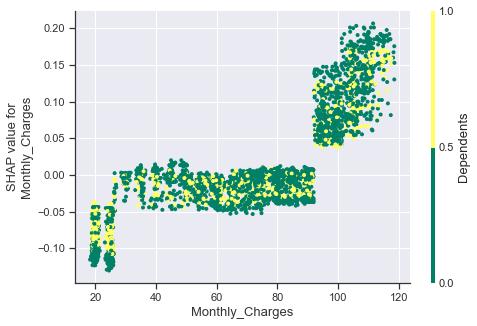

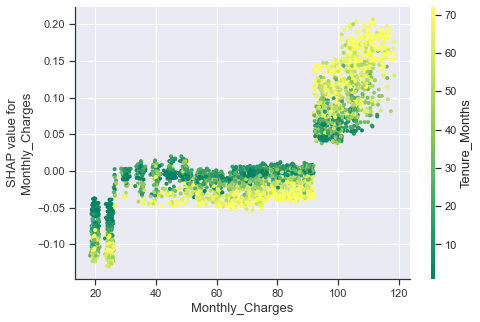

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


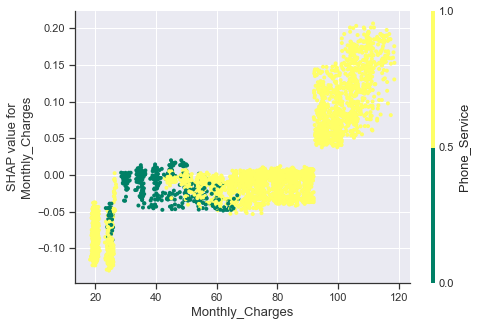

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


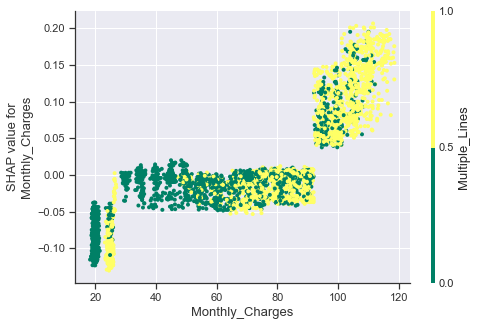

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


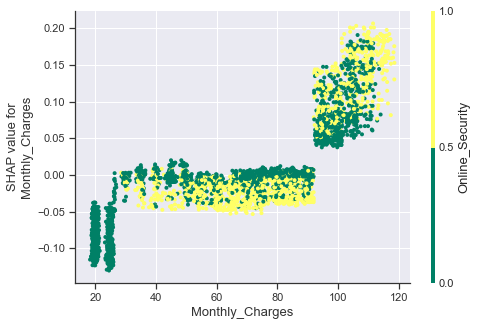

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


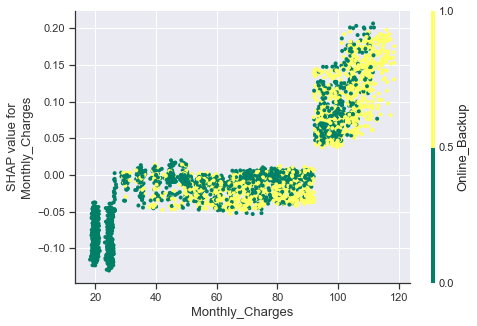

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


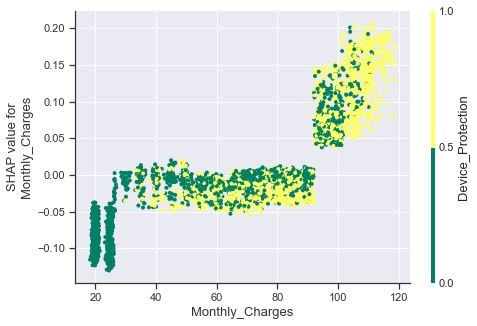

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


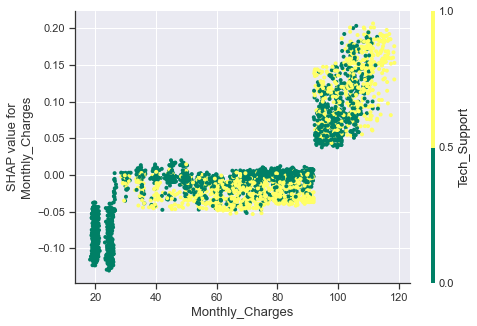

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


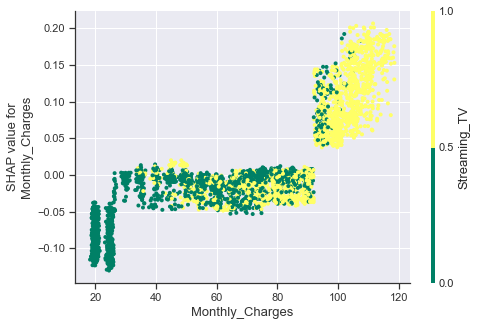

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


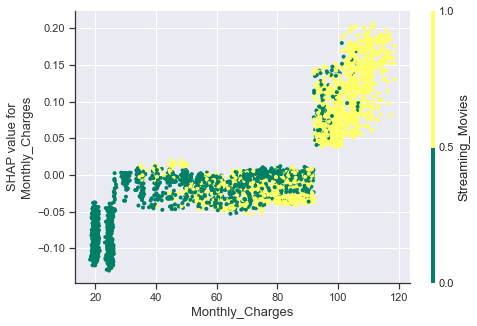

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


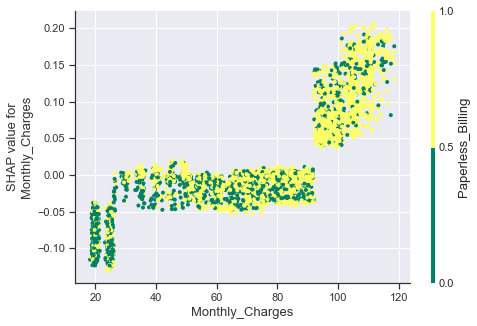

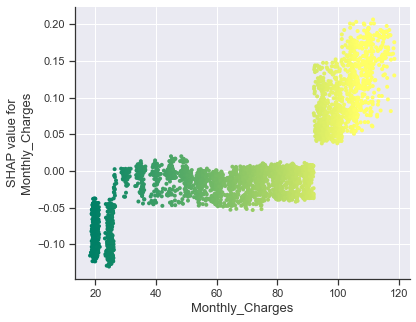

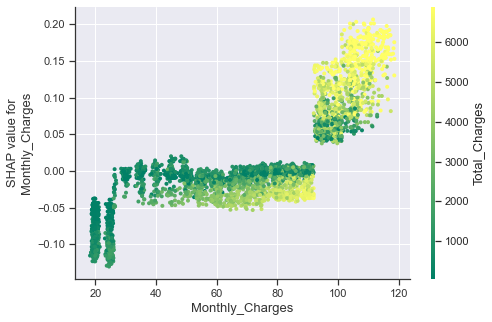

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


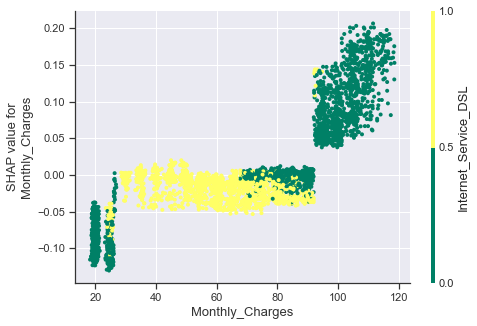

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


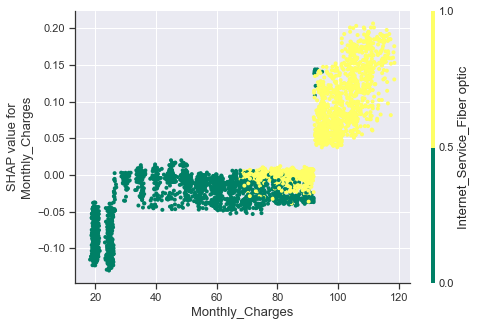

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


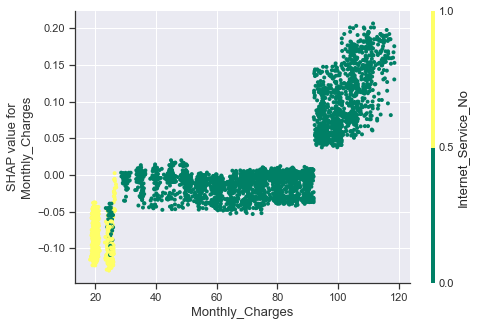

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


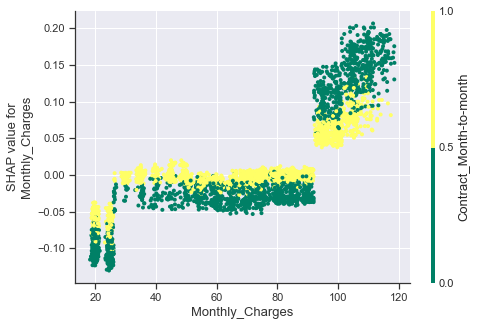

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


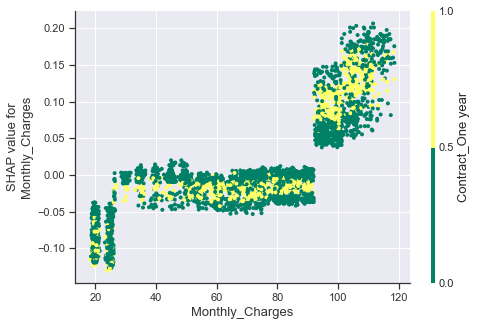

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


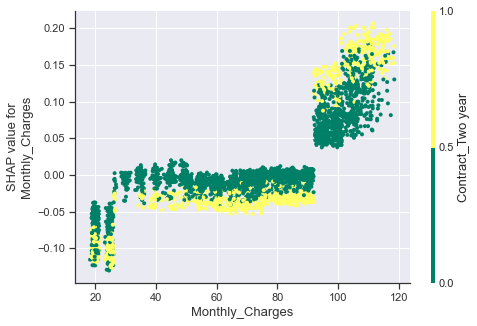

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


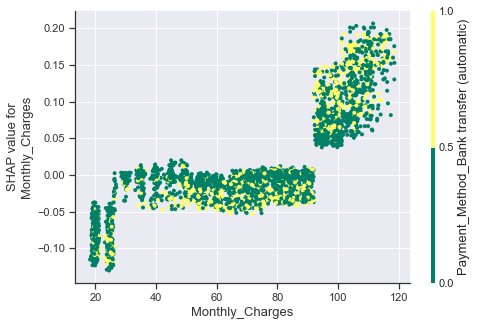

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


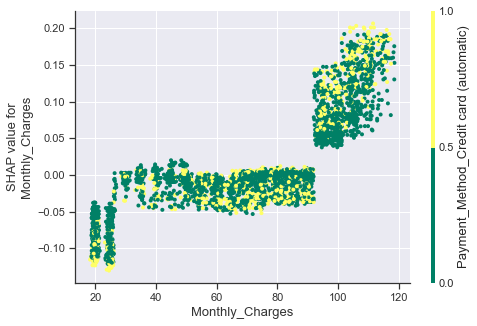

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


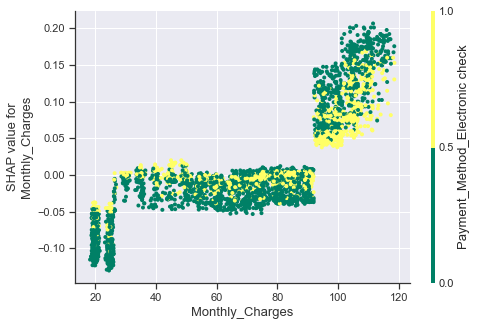

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


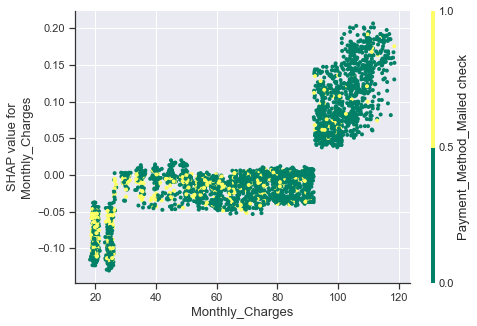

In [63]:
# Check relationship between 'Monthly_Charges' and other features
for i in range(0,len(X_train.columns)):    
    shap.dependence_plot('Monthly_Charges', 
                         shap_values[1], 
                         X_train,
                         interaction_index= X_train.columns[i], 
                         cmap=plt.get_cmap("summer"))